In [1]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cu124.html --quiet > /dev/null 2>&1
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.6.0+cu124.html --quiet > /dev/null 2>&1
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.6.0+cu124.html --quiet > /dev/null 2>&1
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html --quiet > /dev/null 2>&1
!pip install torch-geometric --quiet > /dev/null 2>&1

In [2]:
# 1. データセット
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='/tmp/Cora', name='Cora') # Cora (論文の被引用ネットワーク)

Processing...
Done!


In [3]:
# Coraは2708もの論文を含み、それぞれの論文が7つのクラスに分けられている。(このデータセットを使って、各ノード(論文)のカテゴリを予測する)
data = dataset[0]

print("=== 論文ノードの特徴サンプル ===")
for i in range(3):
    nonzero_words = data.x[i].nonzero(as_tuple=True)[0].tolist()
    label = int(data.y[i])
    print(f"ノード {i}：カテゴリ {label}")
    print("含まれる単語インデックス:", nonzero_words)
    print('-' * 40)

=== 論文ノードの特徴サンプル ===
ノード 0：カテゴリ 3
含まれる単語インデックス: [19, 81, 146, 315, 774, 877, 1194, 1247, 1274]
----------------------------------------
ノード 1：カテゴリ 4
含まれる単語インデックス: [19, 88, 149, 212, 233, 332, 336, 359, 472, 507, 548, 687, 763, 808, 889, 1058, 1177, 1254, 1257, 1262, 1332, 1339, 1349]
----------------------------------------
ノード 2：カテゴリ 4
含まれる単語インデックス: [19, 89, 128, 322, 381, 480, 507, 551, 647, 702, 715, 912, 1076, 1091, 1177, 1209, 1263, 1314, 1353]
----------------------------------------


In [4]:
# 2. GCNの実装
# NetクラスにNNの構造とforwardメソッドを記入し、その中でGCNConvを呼び出す。
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [5]:
# 3. GCNの学習
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()  # モデルを訓練モードにする。
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [6]:
# 4. 評価
model.eval()  # モデルを評価モードにする。
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Acc: {:.4f}' .format(acc))

Acc: 0.7970


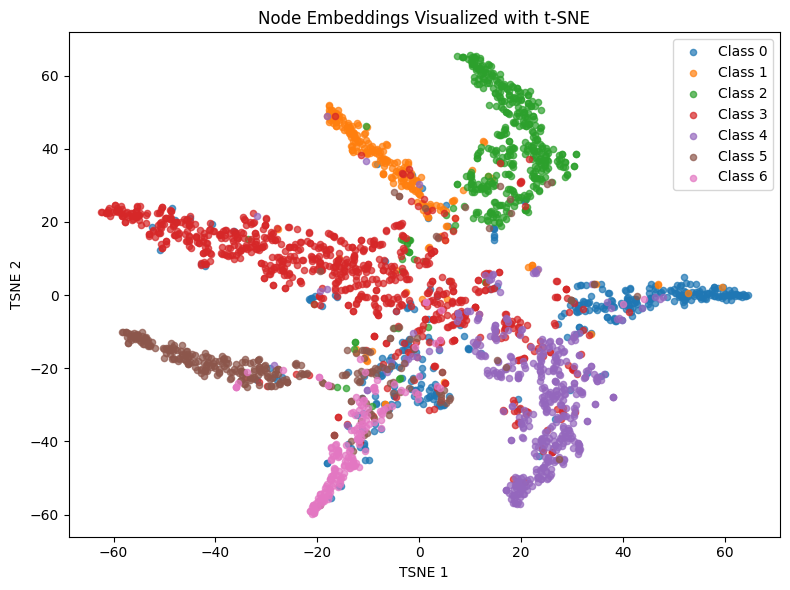

In [7]:
# 5. ノード埋め込み(次元削減)と可視化
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 埋め込み特徴を取得 (log_softmaxの直前、すなわちconv2の出力を使いたい場合は少し修正必要)
model.eval()
with torch.no_grad():
    out = model(data)  # log_softmax出力
    embeddings = out.cpu().numpy()  # t-SNE対象

# ラベル情報取得
labels = data.y.cpu().numpy()

# t-SNEで2次元に次元削減
z_tsne = TSNE(n_components=2, random_state=42).fit_transform(embeddings)

# 可視化
plt.figure(figsize=(8, 6))
for label in range(dataset.num_classes):
    idx = labels == label
    plt.scatter(z_tsne[idx, 0], z_tsne[idx, 1], label=f'Class {label}', alpha=0.7, s=20)
plt.legend()
plt.title('Node Embeddings Visualized with t-SNE')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.tight_layout()
plt.show()